In [2]:
import pygrib
import numpy as np
from dabry.wind import DiscreteWind
from dabry.ddf_manager import DDFmanager
from dabry.problem import NavigationProblem
from dabry.model import ZermeloGeneralModel
from dabry.misc import Utils
from datetime import datetime, timedelta
import h5py
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt

## Parameters
Select folder and bounds

In [32]:
dirpath = '../data/ecmwf/ensemble/20230825'
bl = np.array((-10, -60))#np.array((42, -43))
tr = np.array((60, -25))#np.array((125, 0))

## Load grid

In [33]:
info = os.listdir(dirpath)[0].split('-')[0]
year, month, day, run = int(info[:4]), int(info[4:6]), int(info[6:8]), int(info[8:10])
grb_name = os.listdir(dirpath)[0]
grbs = pygrib.open(os.path.join(dirpath, grb_name))
grb = grbs.select(name=['U component of wind', 'V component of wind'], typeOfLevel='isobaricInhPa', level=1000)
_, lats, lons = grb[0].data(lon1=bl[0], lon2=tr[0], lat1=bl[1], lat2=tr[1])
shape = lons.shape
if lons.max() > 180.:
    newlons = np.zeros(lons.shape)
    newlons[:] = lons - 360.
    lons[:] = newlons

newlats = np.zeros(lats.shape)
newlats[:] = lats[::-1, :]
lats[:] = newlats

ny, nx = lons.shape
grid = np.zeros((nx, ny, 2))
grid[:] = np.transpose(np.stack((lons, lats)), (2, 1, 0))

## Visualize data

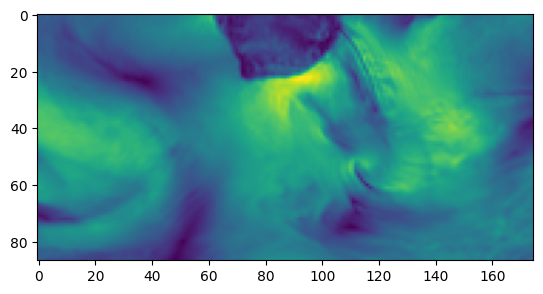

In [34]:
U, _, _ = grb[0].data(lon1=bl[0], lon2=tr[0], lat1=bl[1], lat2=tr[1])
V, _, _ = grb[1].data(lon1=bl[0], lon2=tr[0], lat1=bl[1], lat2=tr[1])
plt.imshow(np.sqrt(U**2 + V**2))

## Check grid shape

In [35]:
lons.shape

(87, 175)

## Load wind data

In [36]:
n_members = 51
nt = len(os.listdir(dirpath))
uv = np.zeros((n_members, nt, nx, ny, 2))
u_l = []
v_l = []
grb_names = [os.path.join(dirpath, f'{year}{month:0>2}{day:0>2}{run:0>2}0000-{h}h-enfo-ef.grib2') for h in [3*i for i in range(nt)]]


with tqdm(total=2*n_members*nt) as pbar:
    for i_t, grb_name in enumerate(grb_names):
        grbs = pygrib.open(grb_name)
        grb = grbs.select(name=['U component of wind', 'V component of wind'], typeOfLevel='isobaricInhPa', level=1000)
        for g in grb:
            i_member = int(g['number'])
            is_v = g['name'].startswith('V')
            data = g.data(lon1=bl[0], lon2=tr[0], lat1=bl[1], lat2=tr[1])[0]
            uv[i_member, i_t, :, :, int(is_v)] = data.transpose()[:, ::-1]
            pbar.update(1)

  0%|          | 0/3060 [00:00<?, ?it/s]

## Dump to wind files

In [39]:
def dump_scenario(i):
    dirname = f'../output/wind_scenarii3_{i}/'
    if not os.path.exists(dirname):
        os.mkdir(dirname)
    with h5py.File(os.path.join(dirname, '_wind.h5'), 'w') as f:
        f.attrs['coords'] = 'gcs'
        f.attrs['units_grid'] = 'rad'
        dset = f.create_dataset('data', (nt, nx, ny, 2), dtype='f8')
        dset[:] = uv[i]
        dset = f.create_dataset('ts', (nt,), dtype='f8')
        dset[:] = [(datetime(year, month, day, run, 0) + timedelta(hours=3*k)).timestamp() for k in range(nt)]
        dset = f.create_dataset('grid', (nx, ny, 2), dtype='f8')
        dset[:] = Utils.DEG_TO_RAD * grid

In [40]:
for k in range(uv.shape[0]):
    dump_scenario(k)

In [16]:
day

10

In [106]:
import json

In [113]:
l = []
with open('../data/ecmwf/ensemble/20230505000000-0h-enfo-ef.index', 'r') as f:
    lines = f.readlines()
    for line in lines:
        l.append(json.loads(line))
l

[{'domain': 'g',
  'date': '20230505',
  'time': '0000',
  'expver': '0001',
  'class': 'od',
  'type': 'cf',
  'stream': 'enfo',
  'step': '0',
  'levtype': 'sfc',
  'param': '10u',
  '_offset': 0,
  '_length': 609069},
 {'domain': 'g',
  'date': '20230505',
  'time': '0000',
  'expver': '0001',
  'class': 'od',
  'type': 'pf',
  'stream': 'enfo',
  'step': '0',
  'levtype': 'sfc',
  'number': '26',
  'param': '10u',
  '_offset': 609069,
  '_length': 609069},
 {'domain': 'g',
  'date': '20230505',
  'time': '0000',
  'expver': '0001',
  'class': 'od',
  'type': 'pf',
  'stream': 'enfo',
  'step': '0',
  'levtype': 'sfc',
  'number': '11',
  'param': '2t',
  '_offset': 1218138,
  '_length': 609069},
 {'domain': 'g',
  'date': '20230505',
  'time': '0000',
  'expver': '0001',
  'class': 'od',
  'type': 'pf',
  'stream': 'enfo',
  'step': '0',
  'levtype': 'sfc',
  'number': '8',
  'param': '2t',
  '_offset': 1827207,
  '_length': 609069},
 {'domain': 'g',
  'date': '20230505',
  'time':

In [79]:
srcfiles = ['../data/ecmwf/ensemble/20230505000000-3h-enfo-ef.grib2.1']
i_member = 1
filename = 'wind.h5'
filepath = '../output/test_ensemble_1/' + filename

def process(grbfile, setup=False, nx=None, ny=None):
    grbs = pygrib.open(grbfile)
    grb = grbs.select(name='U component of wind', typeOfLevel='isobaricInhPa', level=925)[i_member]
    lon_b = (bl[0], tr[0])  # Utils.rectify(bl[0], tr[0])
    U, lats, lons = grb.data(lat1=bl[1], lat2=tr[1], lon1=lon_b[0], lon2=lon_b[1])
    grb = grbs.select(name='V component of wind', typeOfLevel='isobaricInhPa', level=925)[i_member]
    V, _, _ = grb.data(lat1=bl[1], lat2=tr[1], lon1=lon_b[0], lon2=lon_b[1])
    if setup:
        if lons.max() > 180.:
            newlons = np.zeros(lons.shape)
            newlons[:] = lons - 360.
            lons[:] = newlons

        newlats = np.zeros(lats.shape)
        newlats[:] = lats[::-1, :]
        lats[:] = newlats

        ny, nx = U.shape
        grid = np.zeros((nx, ny, 2))
        grid[:] = np.transpose(np.stack((lons, lats)), (2, 1, 0))
        return nx, ny, grid
    else:
        if nx is None or ny is None:
            print('Missing nx or ny', file=sys.stderr)
            exit(1)
        UV = np.zeros((nx, ny, 2))
        UV[:] = np.transpose(np.stack((U, V)), (2, 1, 0))
        UV[:] = UV[:, ::-1, :]
        return UV

# First fetch grid parameters
nx, ny, grid = process(srcfiles[0], setup=True)
nt = len(srcfiles)
UVs = np.zeros((nt, nx, ny, 2))
dates = np.zeros((nt,))
for k, grbfile in enumerate(srcfiles):
    UV = process(grbfile, nx=nx, ny=ny)
    UVs[k, :] = UV
    dates[k] = datetime(2023, 5, 5, 0, 0).timestamp()

In [80]:
with h5py.File(filepath, 'w') as f:
    f.attrs['coords'] = Utils.COORD_GCS
    f.attrs['units_grid'] = Utils.U_RAD
    f.attrs['analytical'] = False
    dset = f.create_dataset('data', (nt, nx, ny, 2), dtype='f8')
    dset[:] = UVs
    dset = f.create_dataset('ts', (nt,), dtype='f8')
    dset[:] = dates
    dset = f.create_dataset('grid', (nx, ny, 2), dtype='f8')
    dset[:] = Utils.DEG_TO_RAD * grid

In [48]:
i_member = 1
wind = DiscreteWind()
bl = np.array((-58, 16))
tr = np.array((-20, 40))
wind.load_from_cds('../data/cds/ensemble', bl, tr, 
                   t_start=datetime(2021, 11, 1, 0, 0).timestamp(), t_end=datetime(2021, 11, 1, 0, 0).timestamp() + 40 * 3600, i_member=i_member)

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.17s/it]


In [49]:
x_init = Utils.DEG_TO_RAD * bl
x_target = Utils.DEG_TO_RAD * tr
model= ZermeloGeneralModel(23, Utils.COORD_GCS)
pb = NavigationProblem(model, x_init, x_target, Utils.COORD_GCS, bl=Utils.DEG_TO_RAD * bl, tr=Utils.DEG_TO_RAD * tr)

In [50]:
ddf = DDFmanager()
ddf.setup()
ddf.set_case(f'test_ensemble_{i_member}')
ddf.clean_output_dir()
ddf.dump_wind(wind)
ddf.log(pb)

In [7]:
grbs = pygrib.open(f'../data/ecmwf/ensemble/20230510/20230510120000-0h-enfo-ef.grib2')

In [8]:
grb = grbs.select(name=['U component of wind', 'V component of wind'], typeOfLevel='isobaricInhPa', level=1000)